In [1]:
# Suppress warnings 
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [156]:
!pip install scikeras

In [65]:

import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set(style="darkgrid")
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [3]:
import tensorflow as tf
tf.random.set_seed(0)
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import LSTM, Dense, Activation, Dropout
from tensorflow.keras.utils import plot_model
from tensorflow.keras import optimizers, backend as K
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [4]:
TRAIN_RANGE = (datetime(1949, 1, 1), datetime(1956, 12, 1))
VALID_RANGE = (datetime(1957, 1, 1), datetime(1958, 12, 1))
TEST_RANGE = (datetime(1959, 1, 1), datetime(1960, 12, 1))
TIMESTEPS = 12  # Input 12 months to predict next month

In [23]:
df = pd.read_csv('train.csv') 

In [ ]:
#Lets check the ditribution of the target variable (Order_Demand)
from matplotlib import rcParams
# figure size in inches
rcParams['figure.figsize'] = 4,2

sns.distplot(df['quantity'], fit=norm)

#Get the QQ-plot
fig = plt.figure()
res = stats.probplot(df['quantity'], plot=plt)
plt.show()

In [24]:
df['date'] = pd.to_datetime(df['date'])
df.reset_index(inplace = True)

In [26]:
df['store_item'] = 'store' + df['store'].astype(str) + '_item' + df['item'].astype(str)


In [36]:
monthly_data = df.groupby('store_item').resample('MS', on = 'date')['quantity'].sum().reset_index()

In [37]:
monthly_data.head()

,store_item,date,quantity
0,store10_item1,2013-01-01,447
1,store10_item1,2013-02-01,469
2,store10_item1,2013-03-01,579
3,store10_item1,2013-04-01,636
4,store10_item1,2013-05-01,710


In [101]:
product_ids = ['store2_item28', 'store2_item15', 'store2_item18', 'store8_item15', 'store2_item13']
selected_products = monthly_data[monthly_data['store_item'].isin(product_ids)]

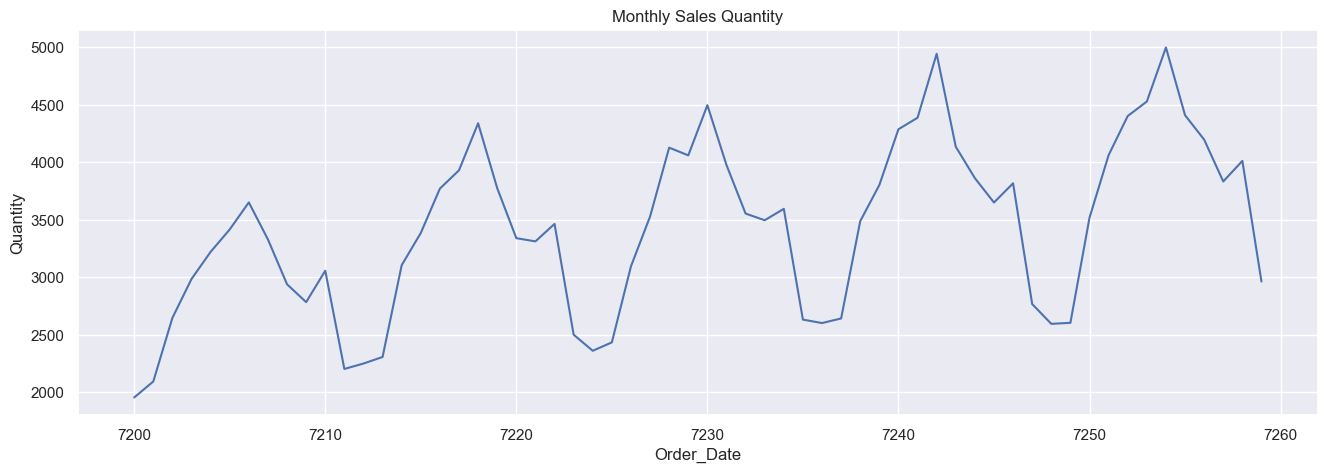

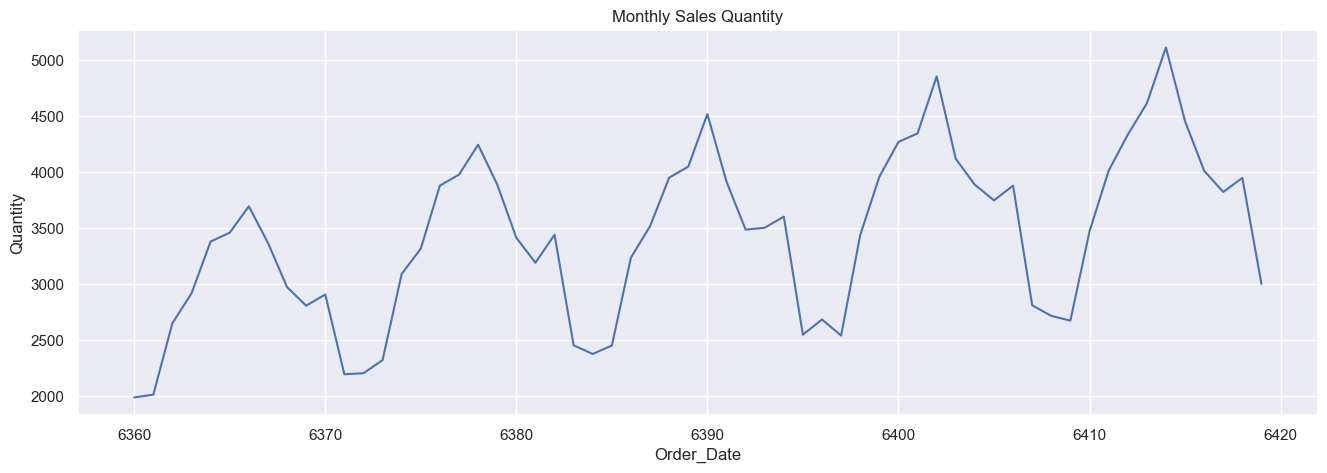

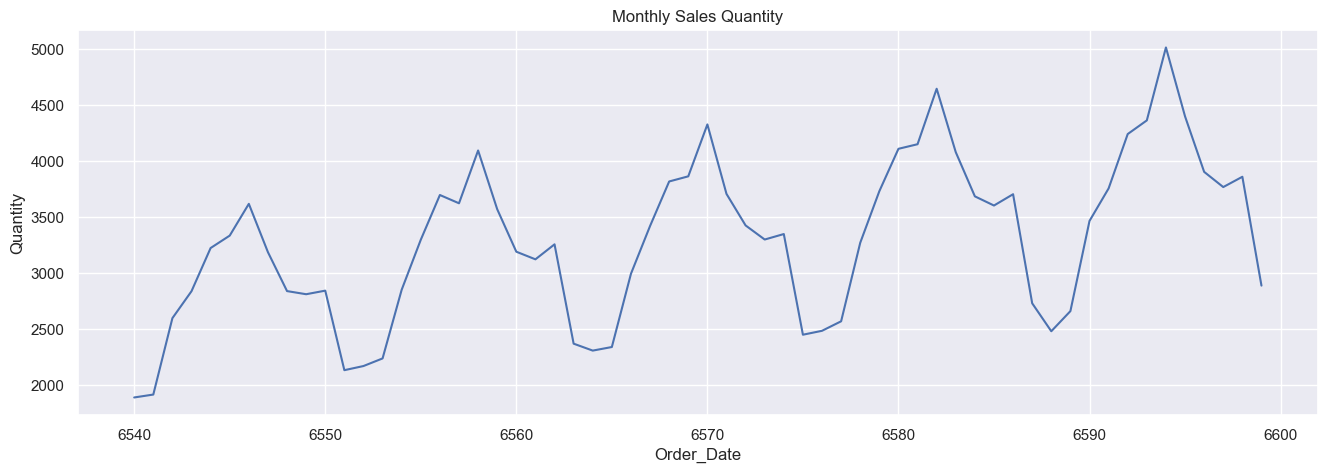

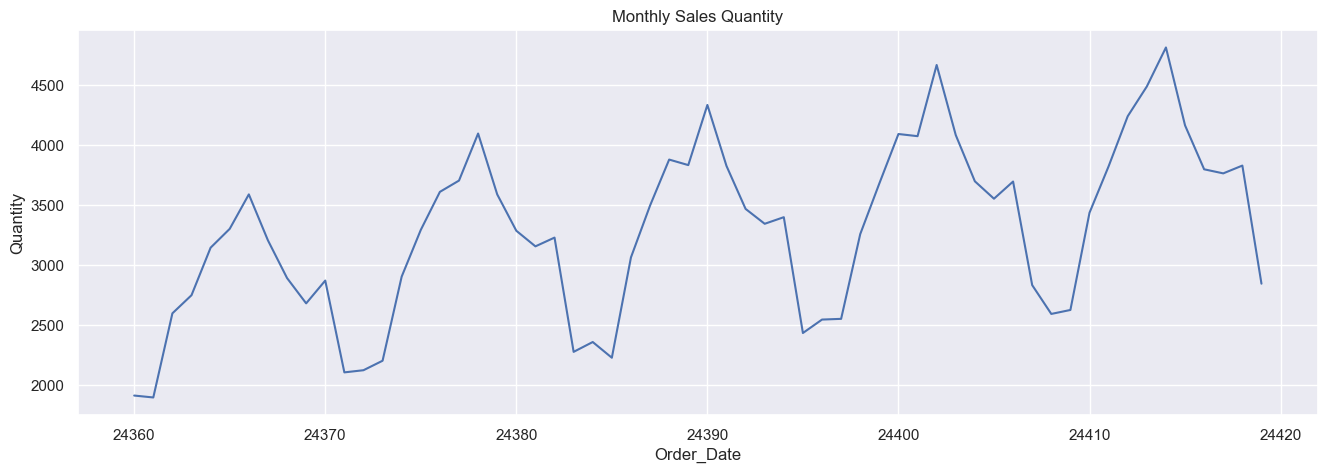

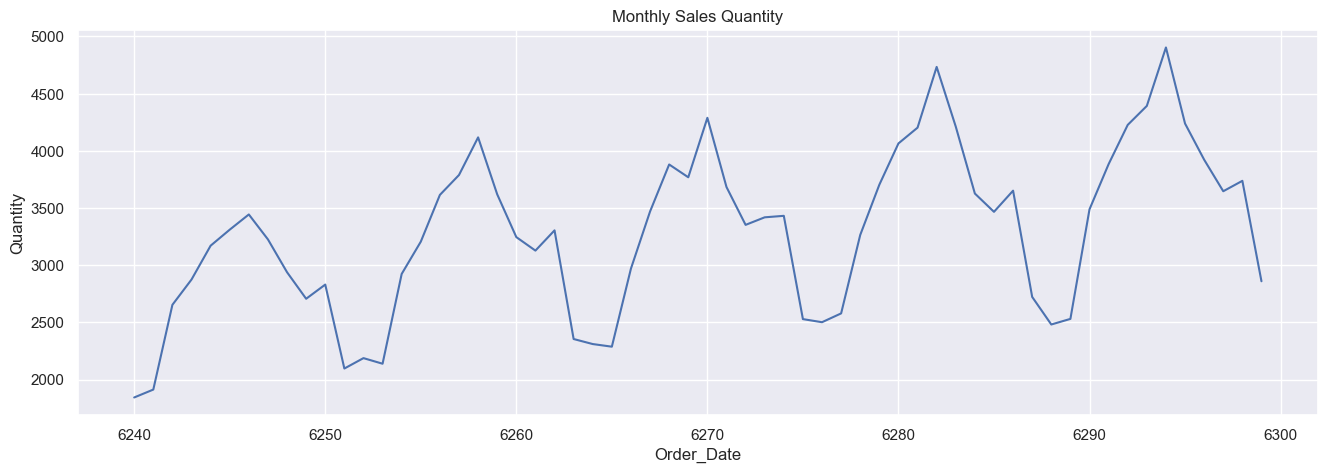

In [102]:
for product in product_ids:
    data = monthly_data[monthly_data['store_item'] == product] 
    monthly_graph = data['quantity'].plot(figsize = (16,5), title="Monthly Sales Quantity")
    monthly_graph.set(xlabel='Order_Date',ylabel='Quantity')
    plt.show()
    

In [44]:
monthly_data.head()

,store_item,date,quantity
0,store10_item1,2013-01-01,447
1,store10_item1,2013-02-01,469
2,store10_item1,2013-03-01,579
3,store10_item1,2013-04-01,636
4,store10_item1,2013-05-01,710


In [103]:
len(selected_products)

300

In [104]:
pivot_df = selected_products.pivot(index='date', columns='store_item', values='quantity').fillna(0)

In [105]:
pivot_df.head()

store_item,store2_item13,store2_item15,store2_item18,store2_item28,store8_item15
date,,,,,
2013-01-01,1843,1989,1885,1956,1914
2013-02-01,1912,2014,1911,2095,1898
2013-03-01,2653,2651,2594,2648,2599
2013-04-01,2874,2917,2835,2986,2750
2013-05-01,3170,3379,3221,3222,3146


In [106]:
len(pivot_df)

60

In [120]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(pivot_df)


In [138]:
def create_sequences(data, sequence_length):
    sequences = []
    targets = []
    print(len(data))
    for i in range(len(data) - sequence_length):
        sequences.append(data[i:i+sequence_length])
        targets.append(data[i+sequence_length])
    return np.array(sequences), np.array(targets)

sequence_length = 10
X, y = create_sequences(scaled_data, sequence_length)
len(X)

60


50

In [139]:
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [149]:
X_train.shape[2]

5

In [144]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

model = Sequential()
model.add(Bidirectional(LSTM(50, return_sequences=True), input_shape=(sequence_length, X_train.shape[2])))
model.add(Dropout(0.2)) 
model.add(Bidirectional(LSTM(50)))
model.add(Dropout(0.2)) 
model.add(Dense(X_train.shape[2]))  # Output layer with the number of SKUs

model.compile(optimizer='adam', loss='mean_squared_error')


early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss', mode='min')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)


In [145]:
history = model.fit(X_train, y_train, epochs=100, batch_size=8, validation_split=0.2,
                    callbacks=[early_stopping, model_checkpoint, reduce_lr])


Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 315ms/step - loss: 0.1777 - val_loss: 0.1323 - learning_rate: 0.0010
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0785 - val_loss: 0.0935 - learning_rate: 0.0010
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0704 - val_loss: 0.1127 - learning_rate: 0.0010
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0904 - val_loss: 0.0805 - learning_rate: 0.0010
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0591 - val_loss: 0.0767 - learning_rate: 0.0010
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0580 - val_loss: 0.0760 - learning_rate: 0.0010
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0579 - val_loss: 0.0732 - learning_rate: 0.0010
Epoch 8/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0556 - val_loss: 0.0713 - learning_rate: 0.0010
Epoch 9/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0578 - val_loss: 0.0706 - learning_rate: 0.0010
Epoch 10/100
4/4 ━━━━━━━━━━

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0137 - val_loss: 0.0350 - learning_rate: 0.0010
Epoch 59/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0134 - val_loss: 0.0176 - learning_rate: 0.0010
Epoch 60/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0189 - val_loss: 0.0249 - learning_rate: 0.0010
Epoch 61/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0152 - val_loss: 0.0318 - learning_rate: 0.0010
Epoch 62/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0120 - val_loss: 0.0207 - learning_rate: 0.0010
Epoch 63/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0174 - val_loss: 0.0202 - learning_rate: 0.0010
Epoch 64/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0144 - val_loss: 0.0185 - learning_rate: 0.0010
Epoch 65/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0151 - val_loss: 0.0211 - learning_rate: 0.0010
Epoch 66/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0159 - val_loss: 0.0274 - learning_rate: 0.0010
Epoch 67/100
4/4 ━━━━━━━━━━━━━━━

In [146]:
model.load_weights('best_model.keras')

predictions = model.predict(X_test)
# Inverse transform the predictions to get them back to the original scale
predictions = scaler.inverse_transform(predictions)

# For comparison, inverse transform the actual y_test values as well
y_test_inverse = scaler.inverse_transform(y_test)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


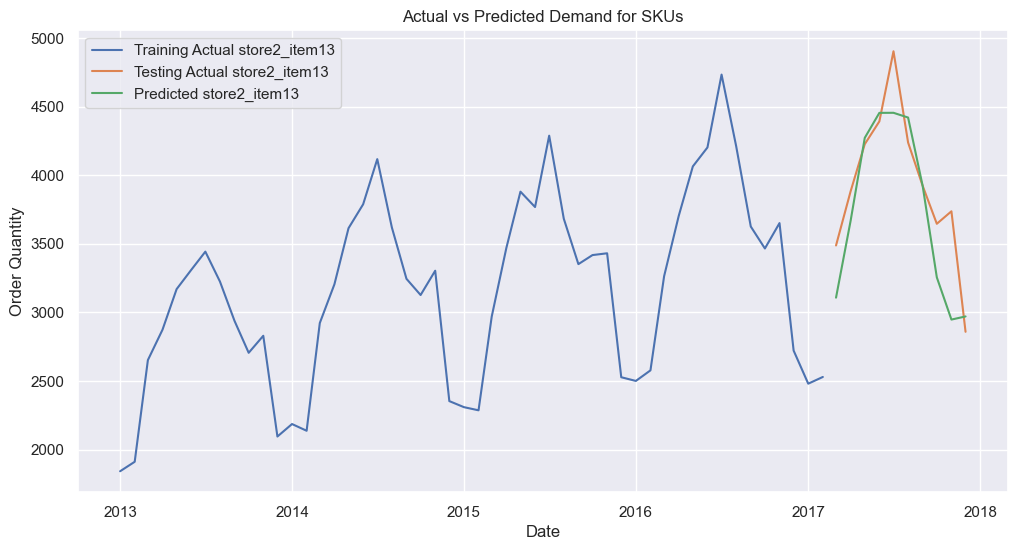

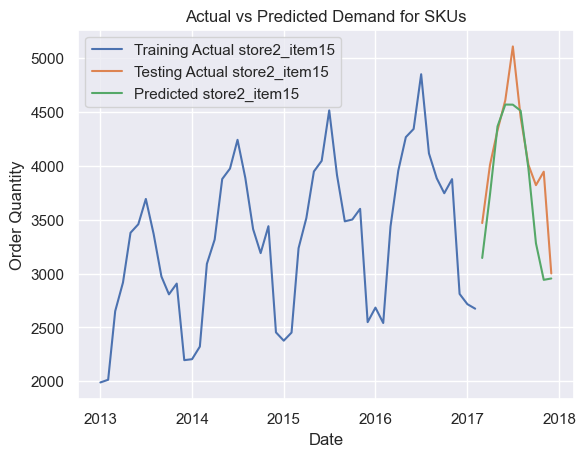

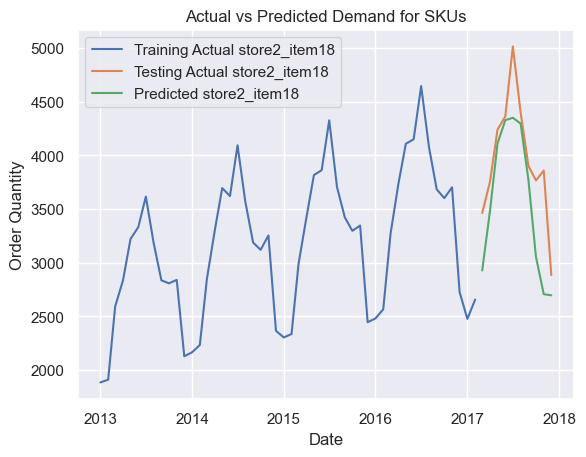

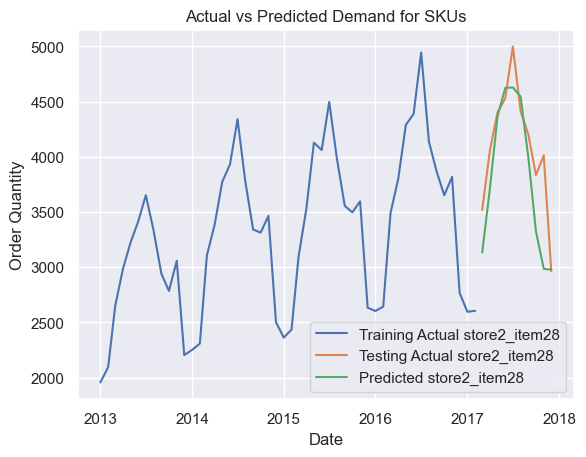

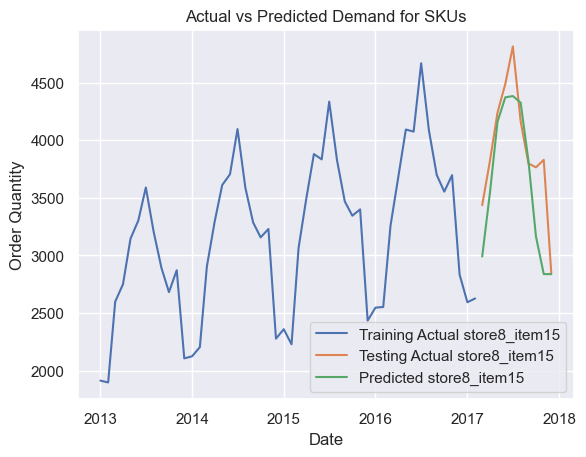

In [147]:
import matplotlib.pyplot as plt

# Plot the actual vs predicted values for each SKU
plt.figure(figsize=(12, 6))
for i, sku in enumerate(pivot_df.columns):
    # Plot training data
    plt.plot(pivot_df.index[:train_size + sequence_length], scaler.inverse_transform(scaled_data)[:train_size + sequence_length, i], label=f'Training Actual {sku}')
    
    # Plot testing data
    plt.plot(pivot_df.index[train_size + sequence_length:], y_test_inverse[:, i], label=f'Testing Actual {sku}')
    plt.plot(pivot_df.index[train_size + sequence_length:], predictions[:, i], label=f'Predicted {sku}')

    plt.title('Actual vs Predicted Demand for SKUs')
    plt.xlabel('Date')
    plt.ylabel('Order Quantity')
    plt.legend()
    plt.show()

In [136]:
# Create a DataFrame for actual vs predicted values
comparison_df = pd.DataFrame(data={
    'Date': pivot_df.index[train_size + sequence_length:],
})

for i, sku in enumerate(pivot_df.columns):
    comparison_df[f'Actual_{sku}'] = y_test_inverse[:, i]
    comparison_df[f'Predicted_{sku}'] = predictions[:, i]

# Display the comparison DataFrame
print(comparison_df.head())


        Date  Actual_store2_item13  Predicted_store2_item13  \
0 2017-03-01                3488.0              2982.914307   
1 2017-04-01                3883.0              3510.004395   
2 2017-05-01                4226.0              4112.168457   
3 2017-06-01                4392.0              4357.463379   
4 2017-07-01                4903.0              4439.147461   

   Actual_store2_item15  Predicted_store2_item15  Actual_store2_item18  \
0                3469.0              3197.913330                3463.0   
1                4009.0              3757.651611                3754.0   
2                4331.0              4348.971680                4240.0   
3                4610.0              4559.305664                4362.0   
4                5109.0              4575.519043                5014.0   

   Predicted_store2_item18  Actual_store2_item28  Predicted_store2_item28  \
0              3044.660400                3519.0              3102.033447   
1              3606.34

In [137]:
# Calculate RMSE and R² for each SKU
rmse_scores = []
r2_scores = []

for i, sku in enumerate(pivot_df.columns):
    rmse = np.sqrt(mean_squared_error(y_test_inverse[:, i], predictions[:, i]))
    r2 = r2_score(y_test_inverse[:, i], predictions[:, i])
    rmse_scores.append((sku, rmse))
    r2_scores.append((sku, r2))
    print(f'SKU: {sku}, RMSE: {rmse}, R²: {r2}')


SKU: store2_item13, RMSE: 382.90810246676, R²: 0.47733879398122314
SKU: store2_item15, RMSE: 381.6600079883507, R²: 0.5409962531540424
SKU: store2_item18, RMSE: 376.62770358557634, R²: 0.5332492532953437
SKU: store2_item28, RMSE: 423.369960133689, R²: 0.38129297348648317
SKU: store8_item15, RMSE: 445.92097980119075, R²: 0.2713078267852025


In [158]:
from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasRegressor

In [151]:
def build_model(sequence_length):
    model = Sequential()
    model.add(Bidirectional(LSTM(50, return_sequences=True), input_shape=(sequence_length, X_train.shape[2])))
    model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(50)))
    model.add(Dropout(0.2))
    model.add(Dense(X_train.shape[2]))  # Output layer with the number of SKUs

    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [161]:
keras_regressor = KerasRegressor(build_fn=build_model, sequence_length=sequence_length, verbose=0)


In [162]:
param_grid = {
    'sequence_length': [3, 4, 5, 6, 7],  # Adjust the sequence length
    'batch_size': [4, 8, 16, 32],         # Adjust the batch size
    'epochs': [20, 30, 40, 50]            # Adjust the number of epochs
}

# Create the GridSearchCV object
model = build_model(sequence_length)


In [163]:
grid = GridSearchCV(estimator=keras_regressor, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', verbose=2)

In [ ]:
grid_result = grid.fit(X_train, y_train)

# Get the best parameters
best_params = grid_result.best_params_
print("Best Parameters:", best_params)

# Rebuild the model with the best parameters
best_sequence_length = best_params['sequence_length']
best_batch_size = best_params['batch_size']
best_epochs = best_params['epochs']

Fitting 3 folds for each of 80 candidates, totalling 240 fits
[CV] END .........batch_size=4, epochs=20, sequence_length=3; total time=  10.3s
[CV] END .........batch_size=4, epochs=20, sequence_length=3; total time=  10.9s
[CV] END .........batch_size=4, epochs=20, sequence_length=3; total time=  10.3s
[CV] END .........batch_size=4, epochs=20, sequence_length=4; total time=  13.6s
[CV] END .........batch_size=4, epochs=20, sequence_length=4; total time=  12.2s
[CV] END .........batch_size=4, epochs=20, sequence_length=4; total time=  12.0s
[CV] END .........batch_size=4, epochs=20, sequence_length=5; total time=  11.2s
[CV] END .........batch_size=4, epochs=20, sequence_length=5; total time=  12.8s
[CV] END .........batch_size=4, epochs=20, sequence_length=5; total time=  11.4s
[CV] END .........batch_size=4, epochs=20, sequence_length=6; total time=  14.4s
[CV] END .........batch_size=4, epochs=20, sequence_length=6; total time=  12.8s
[CV] END .........batch_size=4, epochs=20, sequ